In [1]:
using SciMLSensitivity
using DifferentialEquations
using SciMLSensitivity   # or DiffEqSensitivity if you prefer
using Zygote
using Optimisers         # for optimizer & update
using LinearAlgebra
using DifferentialEquations
using Flux
using Plots
using Optimization
using OptimizationOptimisers
using Zygote
using DataFrames

using Random
Random.seed!(42)
println("All the nessecessary packages have been imported")

All the nessecessary packages have been imported


In [2]:

# Hodgkin-Huxley Model Parameters (Global Constants)


# Physical Constants
const Cm = 1.0        # μF/cm^2
const g_Na = 120.0    # mS/cm^2
const g_K = 36.0      # mS/cm^2
const g_L = 0.3       # mS/cm^2
const E_Na = 50.0     # mV
const E_K = -77.0     # mV
const E_L = -54.387   # mV

-54.387

In [3]:
# --- Cell 2: Known Physics & Stimulus ---

# Voltage-gated ion channel kinetics
α_n(V) = 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))
β_n(V) = 0.125 * exp(-(V + 65) / 80)
α_m(V) = 0.1 * (V + 40) / (1 - exp(-(V + 40) / 10))
β_m(V) = 4.0 * exp(-(V + 65) / 18)
α_h(V) = 0.07 * exp(-(V + 65) / 20)
β_h(V) = 1 / (1 + exp(-(V + 35) / 10))

# Steady-state & time-constant functions for the 2D model
m_inf(V) = α_m(V) / (α_m(V) + β_m(V))
h_inf(V) = α_h(V) / (α_h(V) + β_h(V))
n_inf(V) = α_n(V) / (α_n(V) + β_n(V))
tau_n(V) = 1 / (α_n(V) + β_n(V))

println("Physics of neural dynamics has been defined")



Physics of neural dynamics has been defined


In [4]:
function Stimulus(t)
    # A 1ms pulse starting at 10ms
    return(t>-10.0 && t<11.0) ? 20 : 0.0
end

println(" An extra current form neighbour to generate a pulse")

In [5]:



function hodgkin_huxley_reduced!(du, u, p, t)
    V, n = u
    I_ext = Stimulus(t)

    # Physics Engine
    I_Na = g_Na * m_inf(V)^3 * h_inf(V) * (V - E_Na)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    
    du[1] = (I_ext - I_Na - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end

# 1. Generate Truth
u0_true = [-65.0, n_inf(-65.0)]
prob_true = ODEProblem(hodgkin_huxley_reduced!, u0_true, (0.0, 50.0))
sol_true = solve(prob_true, Rodas5P(), saveat=0.25, abstol=1e-8, reltol=1e-8)

clean_V = sol_true[1, :]
t_train = sol_true.t

# 2. Apply "Laboratory Quality" Noise
# 0.8 mV is cleaner, standard high-quality recording noise
noise_level = 0.3
noise = noise_level .* randn(length(clean_V))
data_V = clean_V .+ noise



 An extra current form neighbour to generate a pulse


201-element Vector{Float64}:
 -65.10900724443553
 -60.0137215086866
 -54.76655815008801
 -46.24093103893912
 -30.481627758811126
 -21.914561598958343
 -22.46535746124091
 -26.777329304820157
 -31.979761290833437
 -36.3646711216252
   ⋮
 -64.78170519208786
 -65.3312649156792
 -65.23932959310086
 -65.23980991180075
 -64.45739920256945
 -65.25049007215281
 -65.45606436618846
 -65.05578366503251
 -65.05921519290071

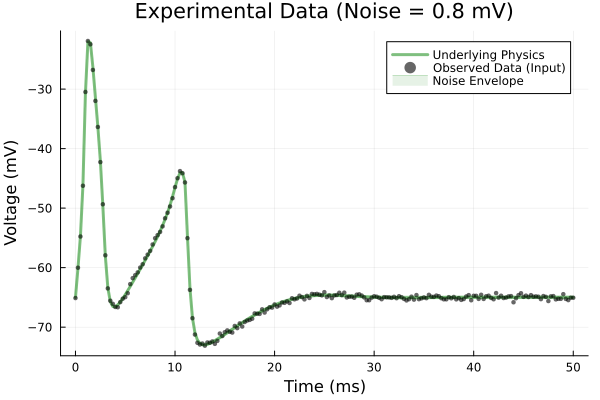

Data Quality Improved. Noise set to 0.8 mV.


In [6]:
# 3. High-Fidelity Visualization
# Using smaller dots (ms=2) and plotting the noisy path as a thin line for clarity
p_clean = plot(t_train, clean_V, label="Underlying Physics", 
               lw=3, color=:green, alpha=0.5)
               
scatter!(p_clean, t_train, data_V, label="Observed Data (Input)", 
         color=:black, ms=2.5, alpha=0.6, markerstrokewidth=0)

# Add a "Confidence Band" to show where the noise should fall
plot!(p_clean, t_train, clean_V .+ noise_level, color=:green, lw=0, fill=(clean_V .- noise_level, :green, 0.1), label="Noise Envelope")

title!(p_clean, "Experimental Data (Noise = 0.8 mV)")
xlabel!("Time (ms)")
ylabel!("Voltage (mV)")
display(p_clean)

println("Data Quality Improved. Noise set to 0.8 mV.")

In [7]:
U = Chain(
    Dense(1,15, tanh,init = Flux.glorot_uniform),
    # Dense(15,30,tanh,init = Flux.glorot_uniform),
    Dense(15,1,init=Flux.glorot_uniform)
) |> f64

Chain(
  Dense(1 => 15, tanh),                 # 30 parameters
  Dense(15 => 1),                       # 16 parameters
)                   # Total: 4 arrays, 46 parameters, 576 bytes.

In [8]:
# Extract the trainable parameters (p_nn) and the re-structuring function (re)
p_nn, re = Flux.destructure(U)
println("Recruit Constructed. Parameters: ", eltype(p_nn))


Recruit Constructed. Parameters: Float64


## The hybrid UDE

In [9]:


# Define the UDE function with the embedded neural network
function ude_dynamics!(du, u, p, t)
    V, n = u
    # p --> p_nn neural network parameters
    # Neural network component to learn the unknown current
    # we will normalize V roughly ( divide by 100) to keep inputs clean for the NN

    nn_input = V / 100.0
    # We divide V by 100.0 to keep inputs small for the Neural Network
    # Example: -65mV becomes -0.65

    nn_I_Na = re(p)([nn_input])[1]
    # Known physics components
    I_ext = Stimulus(t)
    I_K  = g_K  * n^4 * (V - E_K)
    I_L  = g_L * (V - E_L)
    
    # The hybrid dynamics equation
    du[1] = (I_ext + nn_I_Na - I_K - I_L) / Cm
    du[2] = (n_inf(V) - n) / tau_n(V)
end
println("Hybrid Engine Assembled.")

Hybrid Engine Assembled.


In [10]:
tspan = (0.0, 50.0) 
prob_nn = ODEProblem(ude_dynamics!,u0_true,tspan , p_nn)
const lambda_reg = 0.01
function predict_ude(p)
    # build problem with the current flattened NN params


    _prob=remake(prob_nn,p=p)
    
    
    solve(_prob, Rodas5P(), saveat=t_train, 
        abstol=1e-8, reltol=1e-8,
          sensealg=InterpolatingAdjoint(autojacvec=ZygoteVJP()))
end



function loss(p)
    pred = predict_ude(p)
    if pred.retcode != :Success
        return 1e6
    end
    pred_V = pred[1, :]
    loss_val = sum(abs2, pred_V .- data_V)
        # 4. Regularization (L2 Penalty)
    # Punishment for complex/large weights
    regularization_loss = lambda_reg * sum(abs2, p)
    # 5. Total Objective
    total_loss = loss_val + regularization_loss

    return total_loss
end

println("Objective Functions Defined.")

Objective Functions Defined.


In [26]:
const history_losses = []
const history_params = Vector{Float64}[]


function master_callback(p,l)

    push!(history_losses, l)
    iter=length(history_losses)
    if iter % 50 == 0 
        println("Mission Step : $iter | Loss: $l")
    end
    return false
end


master_callback (generic function with 1 method)

In [12]:

# Define the optimization problem
optf = Optimization.OptimizationFunction((x, p) -> loss(x), Optimization.AutoZygote())
optprob = Optimization.OptimizationProblem(optf, p_nn)

# Execute the training mission
println("Commencing Training...")
# We use a lower learning rate for stability and more iterations.
# This is a full-scale training run. It may take a few minutes.
res = Optimization.solve(optprob, OptimizationOptimisers.Adam(0.04), 
                         callback=callback, maxiters=2000)

println("--- TRAINING COMPLETE ---")
println("Training Complete. Final Loss: ", res.objective)

Commencing Training...
Iteration: 50 | Loss: 5066.384844885011
Iteration: 100 | Loss: 3257.7778354181432
Iteration: 150 | Loss: 2663.9041166734323
Iteration: 200 | Loss: 1856.0615526970487
Iteration: 250 | Loss: 1403.201689803285
Iteration: 300 | Loss: 1304.8318758932664
Iteration: 350 | Loss: 1260.1633521634935
Iteration: 400 | Loss: 1219.0206681041368
Iteration: 450 | Loss: 1160.9464345222234
Iteration: 500 | Loss: 1116.9305778565001
Iteration: 550 | Loss: 1079.6832821929734
Iteration: 600 | Loss: 1048.8007980449208
Iteration: 650 | Loss: 1021.8916575742189
Iteration: 700 | Loss: 992.8184244991985
Iteration: 750 | Loss: 947.4865037119158
Iteration: 800 | Loss: 854.0711601527207
Iteration: 850 | Loss: 357.32768872673046
Iteration: 900 | Loss: 235.49651517774203
Iteration: 950 | Loss: 192.34687066993544
Iteration: 1000 | Loss: 152.67278650053262
Iteration: 1050 | Loss: 129.63643844449197
Iteration: 1100 | Loss: 128.5068744064643
Iteration: 1150 | Loss: 100.7513330511293
Iteration: 1200

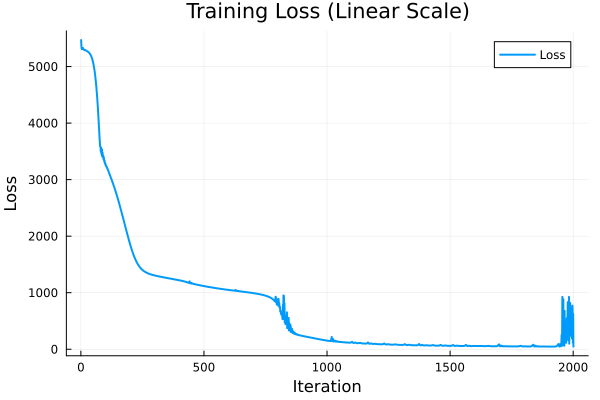

In [14]:
plot(losses,
     xlabel="Iteration",
     ylabel="Loss",
     title="Training Loss (Linear Scale)",
     label="Loss",
     lw=2)


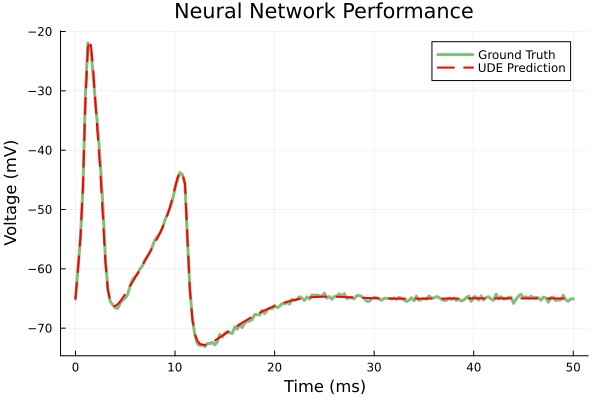

In [15]:

final_sol = predict_ude(res.u)

p2 = plot(t_train, data_V, label="Ground Truth", lw=3, alpha=0.5, color=:green)
plot!(p2, final_sol.t, final_sol[1,:], label="UDE Prediction", lw=2, color=:red, linestyle=:dash)
title!(p2, "Neural Network Performance")
xlabel!("Time (ms)")
ylabel!("Voltage (mV)")
display(p2)

In [ ]:
 losses_phase2    = []

callback_phase2 = function (p, l)
    push!(losses_phase2, l)
    
    if length(losses_phase2) % 50 == 0
        current_iter = length(losses) + length(losses_phase2)
        println("Total iteration : $current_iter | Phase 2 LOSS : $l")
    end
    
    return false
end


#19 (generic function with 1 method)

In [18]:
optprob_phase2 = Optimization.OptimizationProblem(optf, res.u)
es2 = Optimization.solve(optprob_phase2, OptimizationOptimisers.Adam(0.01), 
                          callback=callback_phase2, maxiters=1000)

Total iteration : 2051 | Phase 2 LOSS : 47.140404863113005
Total iteration : 2101 | Phase 2 LOSS : 45.83145298430249
Total iteration : 2151 | Phase 2 LOSS : 45.6301558445303
Total iteration : 2201 | Phase 2 LOSS : 45.40313675904584
Total iteration : 2251 | Phase 2 LOSS : 45.147023948681124
Total iteration : 2301 | Phase 2 LOSS : 44.86574334266223
Total iteration : 2351 | Phase 2 LOSS : 44.562482829515375
Total iteration : 2401 | Phase 2 LOSS : 44.24004777063573
Total iteration : 2451 | Phase 2 LOSS : 43.90107544153042
Total iteration : 2501 | Phase 2 LOSS : 43.548254212751715
Total iteration : 2551 | Phase 2 LOSS : 43.18441742346478
Total iteration : 2601 | Phase 2 LOSS : 42.81265638443184
Total iteration : 2651 | Phase 2 LOSS : 42.43634647137504
Total iteration : 2701 | Phase 2 LOSS : 42.05908435913487
Total iteration : 2751 | Phase 2 LOSS : 41.684501408698935
Total iteration : 2801 | Phase 2 LOSS : 41.31610879376584
Total iteration : 2851 | Phase 2 LOSS : 40.957044510630965
Total ite

retcode: Default
u: 46-element Vector{Float64}:
   2.8640143655292905
   3.1475580207068816
  10.266009286409252
 -10.366566587288661
  -4.387205890860709
  -0.7512882187469878
  -3.7900108710151286
  11.728211438135206
  -7.219910407811108
  -5.170720736780727
   ⋮
  13.915746881846074
  -4.398459383847964
  16.43980886868284
  -5.570916574910577
  -5.035527380029613
  -9.09332337540015
  -4.2085812347809135
  -5.442236350742709
   1.895876528350726

In [32]:
# plot(losses,
#      xlabel="Iteration",
#      ylabel="Loss",
#      title="Training Loss (Linear Scale)",
#      label="Loss",
#      lw=2)


plot(losses_phase2, xlabel="Iteration 2",ylabel = "Loss", title= "Training Loss (Linear Scale)", label = "Loss 2")


ErrorException: Cannot convert OptimizationProblem{true, OptimizationFunction{true, AutoZygote, var"#17#18", Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Vector{Float64}, SciMLBase.NullParameters, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}} to series data for plotting

In [22]:
losses_phase3 = []

callback_phase3 = function (p , l)
    push!(losses_phase3,l)
    if length(losses_phase3) % 50 == 0 
        currrent_iter = length(losses)+length(losses_phase2)+length(losses_phase3)
        println("Total iteration : $current_iter | Phase 2 LOSS : $l ")
    end
    return false
    
end

#23 (generic function with 1 method)

In [23]:
losses_phase2 = Optimization.OptimizationProblem(optf, res.u)
es2 = Optimization.solve(optprob_phase2,OptimizationOptimisers.Adam(0.05),callback=callback_phase3,maxiters=2000)

MethodError: MethodError: no method matching length(::OptimizationProblem{true, OptimizationFunction{true, AutoZygote, var"#17#18", Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Vector{Float64}, SciMLBase.NullParameters, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}})
The function `length` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  length(!Matched::OptimizationBase.NullData)
   @ OptimizationBase C:\Users\Admin\.julia\packages\OptimizationBase\R2xIG\src\OptimizationBase.jl:32
  length(!Matched::Base.EnvDict)
   @ Base env.jl:232
  length(!Matched::Profile.HeapSnapshot.Nodes)
   @ Profile C:\Users\Admin\.julia\juliaup\julia-1.11.7+0.x64.w64.mingw32\share\julia\stdlib\v1.11\Profile\src\heapsnapshot_reassemble.jl:52
  ...


#19 (generic function with 1 method)

Resuming Training (Phase II)...
Total Iteration: 2051 | Phase II Loss: 47.140404863113005
Total Iteration: 2101 | Phase II Loss: 45.83145298430249
Total Iteration: 2151 | Phase II Loss: 45.6301558445303
Total Iteration: 2201 | Phase II Loss: 45.40313675904584


In [13]:
using OptimizationOptimJL # Essential for L-BFGS/BFGS

In [ ]:
# # Continue from where the previous BFGS left off (res.u)
# optprob_refined = Optimization.OptimizationProblem(optf, res.u)

# println("Commencing Deep Optimization (L-BFGS)...")
# # We attempt to squeeze the last drops of error out
# res_deep = Optimization.solve(optprob_refined, OptimizationOptimJL.LBFGS(), 
#                               maxiters=1000, callback=callback)

# println("Deep Optimization Complete. Final Loss: ", res_deep.objective)

### Phase 2 of training

In [ ]:
# # 1. Create a fresh container for Phase II logs so we can plot them separately
# losses_phase2 = Float64[]

# callback_phase2 = function (p, l)
#     push!(losses_phase2, l)
#     # Print logs relative to Phase II start
#     if length(losses_phase2) % 50 == 0
#         current_iter = length(losses) + length(losses_phase2)
#         println("Total Iteration: $current_iter | Phase II Loss: $l")
#     end
#     return false
# end

In [ ]:
# # 1. Create a fresh container for Phase II logs so we can plot them separately
# losses_phase3 = Float64[]

# callback_phase2 = function (p, l)
#     push!(losses_phase3, l)
#     # Print logs relative to Phase II start
#     if length(losses_phase3) % 50 == 0
#         current_iter = length(losses_phase2) + length(losses_phase3)
#         println("Total Iteration: $current_iter | Phase III Loss: $l")
#     end
#     return false
# end

In [ ]:
# # Crucial Step: We build a new problem using 'res.u' (the final weights of Phase I)
# # as the 'u0' (starting weights) of Phase II.
# optprob_phase3 = Optimization.OptimizationProblem(optf, res2.u)

# println("Resuming Training (Phase III)...")

# # 3. EXECUTE WITH REFINED TACTICS
# # We lower the learning rate to 0.01 for finer convergence
# res3 = Optimization.solve(optprob_phase3, OptimizationOptimisers.Adam(0.025), 
#                           callback=callback_phase2, maxiters=3000)

# println("--- PHASE II COMPLETE ---")
# println("Final Loss: ", res3.objective)

In [ ]:
# # deining the time axes

# #phase 1 : 1 : 1000
# iter_1 = 1:length(losses)
# # phase 2 : 1001 to 2000

# iter_2 =  (length(losses)+1) :(length(losses)+ length(losses_phase2))


# # 2. plot phase 1 (The Brech)
# p_history = plot(iter_1, losses, 
#     label="Phase I (Adam 0.02)", 
#     title="Training History: Continuous Assault",
#     xlabel="Iteration", 
#     ylabel="Loss (Log Scale)",
#     yscale=:log10, # Log scale is crucial to see the progress at the bottom
#     color=:blue, lw=2, alpha=0.7)

# # 3. Plot Phase II (The Conquest)
# plot!(p_history, iter_2, losses_phase2, 
#     label="Phase II (Adam 0.01)", 
#     color=:red, lw=2)
# # 4. Mark the Hand-off point
# scatter!(p_history, [length(losses)], [losses[end]], 
#     label="Checkpoint", color=:black, markersize=4)

# display(p_history)

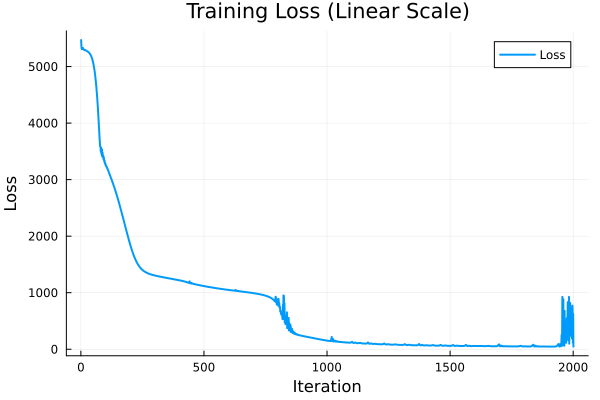

In [13]:
plot(losses,
     xlabel="Iteration",
     ylabel="Loss",
     title="Training Loss (Linear Scale)",
     label="Loss",
     lw=2)


In [ ]:

final_sol = predict_ude(res.u)

p2 = plot(t_train, data_V, label="Ground Truth", lw=3, alpha=0.5, color=:green)
plot!(p2, final_sol.t, final_sol[1,:], label="UDE Prediction", lw=2, color=:red, linestyle=:dash)
title!(p2, "Neural Network Performance")
xlabel!("Time (ms)")
ylabel!("Voltage (mV)")
display(p2)

In [ ]:
# Define the strategic turning point (Where Adam ended and L-BFGS began)
# Based on your logs, Adam finished at iteration 5000.
split_point = 5000

# Separate the data
losses_adam = losses[1:split_point]
# We include the last point of Adam as the start of BFGS to make the line continuous
losses_lbfgs = losses[split_point:end]

# Create the Range for the X-axis to keep them aligned in time
x_adam = 1:split_point
x_lbfgs = split_point:length(losses)

# PLOT THE VICTORY
p_loss = plot(x_adam, losses_adam, 
              title="Training Convergence: The Siege",
              label="Phase I: Adam (The Assault)", 
              color=:blue, lw=2, alpha=0.7,
              xlabel="Iteration", ylabel="Loss (Log Scale)", yaxis=:log)

plot!(p_loss, x_lbfgs, losses_lbfgs, 
      label="Phase II: L-BFGS (Deep Precision)", 
      color=:red, lw=3)

# Add a marker for the final victory point
scatter!(p_loss, [length(losses)], [losses[end]], 
         color=:red, markersize=5, label="Final Loss: 0.026")

display(p_loss)